# TS8: Filtrado No Lineal

## Consignas

En la **TS7** se experimentaron técnicas de **filtrado lineal** para la mitigación de interferencias en la señal electrocardiográfica (ECG).  
Tal vez la interferencia que más exigió el diseño de los filtros digitales ha sido el **movimiento de línea de base del ECG**.  
La misma se trata de oscilaciones de muy baja frecuencia (< 0.5 Hz) y en ocasiones de alta energía.

En esta tarea semanal se analizarán **técnicas no lineales de estimación/substracción** de la señal de movimiento de base $b(n)$:

$$
\hat{x} = s - \hat{b}
$$

Siendo:
- $s$: la señal de ECG registrada con interferencias.  
- $\hat{x}$: la señal filtrada, una estimación del ECG sin interferencias.  

Se pide que implemente ambas estimaciones de $b$ detalladas a continuación:

---

### 1) Filtro de mediana

Se estima $\hat{b}$ a partir de la siguiente expresión:

$$
\hat{b} = \text{med}_{600}(\text{med}_{200}(s))
$$

siendo $\text{med}_t(s)$ el operador de mediana de $t$ milisegundos aplicado sobre la señal $s$, es decir:

$$
\hat{b}[n] = \text{med}(m[n], m[n-1], \dots, m[n-600 \cdot f_s])
$$

donde:

$$
m[n] = \text{med}(s[n], s[n-1], \dots, s[n-200 \cdot f_s])
$$

> 💡 **Ayuda**: Puede utilizar la implementación del filtro de mediana provista en `scipy.signal`.

---

### 2) Interpolación mediante splines cúbicos

A partir de las detecciones provistas en `ecg.mat` (campo `qrs_detections`), puede estimar el **nivel isoeléctrico**,  
es decir, el momento donde la actividad eléctrica cardíaca es aproximadamente nula.  

El intervalo entre la onda **P** y **Q** es el momento más adecuado para estimar las características de la interferencia que origina el movimiento de la línea de base.  
En ese momento el impulso cardíaco es demorado al atravesar el **nódulo aurículo-ventricular**.

Para la localización del segmento PQ, puede valerse de la localización de cada latido (líneas rojas verticales $n_i$)  
y, a partir de la misma, anticipar un tiempo adecuado $n_0$ de manera tal de no incluir la onda P ni Q.  

Esto resultará en un conjunto de valores:

$$
S = \{(m_i, s(m_i)) \,|\, i = 1, 2, \dots, Q \}
$$

donde $m_i = n_i - n_0$ y $Q$ es la cantidad de latidos en el registro (1903).

> ⚠️ Recuerde que la señal de línea de base debe estar muestreada a la misma frecuencia que el ECG, por lo que debería remuestrear dicha señal.  
Puede usar la función de interpolación spline para ello.

La línea de base estimada será:

$$
\hat{b}(n) = \text{spline}_3(S, n) \quad \text{para} \quad n = 1, 2, \dots, N
$$

donde la función `spline3` será la responsable de realizar la interpolación para las $N$ muestras de la señal $s$.

---

### 3) Filtro adaptado (Matched Filter)

Aplique el concepto de **filtro adaptado** para diseñar un detector de latidos.  
Utilice el patrón provisto en el campo `qrs_pattern1`.

> 📚 **Ayuda**: Revise el concepto de filtro adaptado en Wikipedia o la bibliografía de la materia (Porat, sección 14.4.9).

#### a) Pregunta teórica

Explique conceptualmente cómo podría realizar un detector de latidos con la señal resultante del filtro adaptado.  
Discuta la utilidad y limitaciones de este método.

#### b) Implementación práctica

Realice la detección de los latidos, comparando las detecciones obtenidas con las que se incluyen en la variable `qrs_detections`.

Proponga alguna métrica (por ejemplo: **sensibilidad**, **valor predictivo positivo**) para cuantificar la performance del detector.


---

## Introduccion

Ahora, siguiendo los conceptos de la TS7 queremos seguir aplicando distintas maneras de filtras la señal. Hasta el momento, hemos visto metodos de filtrado lineales que funcionan a partir de ciertos principios o algoritmos para alcanzar este objetivo. Pero, ahora nos queremos adentrar en otra parte mas del filtrado en el cual vamos a ver los filtros no lineales, pero antes vamos a explicar un concepto importante:

### Baseline o linea de base

Antes, asumiamos que el ruido y las señales no se solapaban. Por lo que, estos venian en bandas separadas pero esto no ocurre en la realidad y en una gran cantidad de casos tenemos que la señal y el ruido vienen en cierta medida solapadas unas con otras. Con esto en mente, vamos a pensar a la señal de otra manera:

$$
\hat{x} = s - \hat{b}
$$

Siendo:
- $s$: la señal registrada con interferencias.  
- $\hat{x}$: la señal filtrada, una estimación del ECG sin interferencias.
- $\hat{b}$: el ruido que se le añade a la señal. Tambien conocido como baseline.

Con este concepto, pensamos que la señal original va a ser la que registramos menos el ruido que llamamos baseline. A partir de esto es que surje el concepto de estos filtos no lineales. 

---
---

### Filtro de Mediana

Vamos a utilizar el cálculo de la **mediana** sobre la señal. Recordemos que la mediana de una secuencia se define de la siguiente forma:

- Si $N$ es impar:

$$
\text{med}(x_1, x_2, \dots, x_N) = x_{\left(\frac{N+1}{2}\right)}^{\uparrow}
$$

- Si $N$ es par:

$$
\text{med}(x_1, x_2, \dots, x_N) = \frac{1}{2} \left( x_{\left(\frac{N}{2}\right)}^{\uparrow} + x_{\left(\frac{N}{2} + 1\right)}^{\uparrow} \right)
$$

donde $x_i^{\uparrow}$ indica el elemento $i$-ésimo en la secuencia **ordenada de menor a mayor**.

---

#### ¿Cuál es la ventaja de usar la mediana?

A diferencia del promedio, la mediana **es robusta frente a valores atípicos** (outliers).  
Esto significa que si existe un pico abrupto en la señal, el resultado de la mediana no se ve fuertemente afectado, mientras que el promedio sí puede verse alterado significativamente.  
De esta manera, el uso de la mediana permite una estimación más estable del nivel de base en presencia de artefactos o interferencias breves.

---

#### Aplicación al ECG

Con esta propiedad en mente, vamos a calcular la mediana sobre la señal ECG utilizando **ventanas** de tamaño adecuado.

En el caso del ECG, se recomienda aplicar **dos pasadas del filtro de mediana**:

1. **Primera pasada (ventana pequeña):** elimina ruidos de **alta frecuencia**.
2. **Segunda pasada (ventana grande):** elimina oscilaciones de **baja frecuencia** como el movimiento de línea de base.

Esta técnica permite conservar la morfología del ECG y mejorar la estimación del componente útil.

---
---

### Filtro de splines cubicos

Otra opción para estimar la línea de base (**baseline**) es utilizar **interpolación mediante splines cúbicos**.

Para aplicar esta técnica, primero necesitamos identificar **puntos en la señal donde la actividad eléctrica sea mínima**, es decir, donde la señal ECG se aproxime al valor real de la línea de base. Estos puntos nos permitirán construir una estimación de la línea de base $b(n)$.

---

#### ¿Cómo seleccionamos estos puntos?

En el caso del ECG, podemos utilizar las posiciones de los **complejos QRS** (picos de la señal) y retroceder algunas muestras hacia atrás. En esa región, ubicada entre la onda **P** y la onda **Q**, la actividad eléctrica es baja, ya que representa el **intervalo PQ**, donde el impulso cardíaco es demorado al atravesar el nodo aurículo-ventricular.

Para mejorar la estimación y reducir el impacto del ruido:

- En lugar de tomar un único punto por latido, se promedia una **ventana de muestras** (por ejemplo, 20 muestras).
- Esto ayuda a **reducir el ruido de línea (50 Hz)** si el tamaño de la ventana es múltiplo del período de esa frecuencia (20 ms para 50 Hz).
- Además, el promedio en ventana también mitiga la influencia de artefactos o picos anómalos.

Así, obtenemos un conjunto de puntos $\{(t_i, b_i)\}$ que representan estimaciones locales de la línea de base, y que luego se pueden interpolar.

---

### ¿Cómo funciona la interpolación con Splines Cúbicos?

La **interpolación con splines cúbicos** construye una curva suave que **pasa por todos los puntos** dados. El dominio se divide en tramos, y en cada tramo se ajusta un **polinomio de grado 3** (cúbico). Estos polinomios cumplen ciertas condiciones de continuidad:

- La curva es **continua**.
- Su primera y segunda derivada también son continuas en los puntos de unión (nodos).
- Los polinomios se ajustan de forma que la curva sea **suave** y no presente cambios bruscos.

En términos simples:

> La spline cúbica genera una curva que "pasa por los puntos" de manera suave, sin saltos ni ángulos marcados.

---

Una vez construida la spline con los puntos $\{(t_i, b_i)\}$, evaluamos esa función para todos los tiempos $t$ de la señal ECG. Esto nos da una **estimación completa de la línea de base**, que luego se puede restar de la señal original para obtener una versión "limpia" del ECG:

$$
x(n) = s(n) - \hat{b}(n)
$$

donde $s(n)$ es la señal original y $\hat{b}(n)$ la línea de base estimada por interpolación spline.

---
---

### Filtro Adaptado (Matched Filter)

En este último filtro vamos a utilizar un concepto distinto a los anteriores: el **filtro adaptado** o *matched filter*.  
El objetivo es detectar un patrón específico dentro de una señal, y en nuestro caso ese patrón es **un latido típico del ECG**.

Para realizar esta detección, nos vamos a basar en el principio de la **correlación cruzada**. Es decir:

> Vamos a correlacionar la señal con el patrón, y observar en qué puntos la correlación es máxima.  
> Los picos en esta correlación indicarán la presencia de un latido similar al patrón.

Esto se puede interpretar también como una forma de **autocorrelación**, ya que estamos comparando la señal consigo misma (a través de un patrón extraído de ella).  
En definitiva, los **picos de correlación** señalan los instantes donde es más probable que haya un latido.

Implementaremos esto a continuación, y luego analizaremos con más detalle cómo interpretar la señal de salida del filtro adaptado.

---
---

Finalmente, comencemos con la implementacion de los primeros 2 filtos:


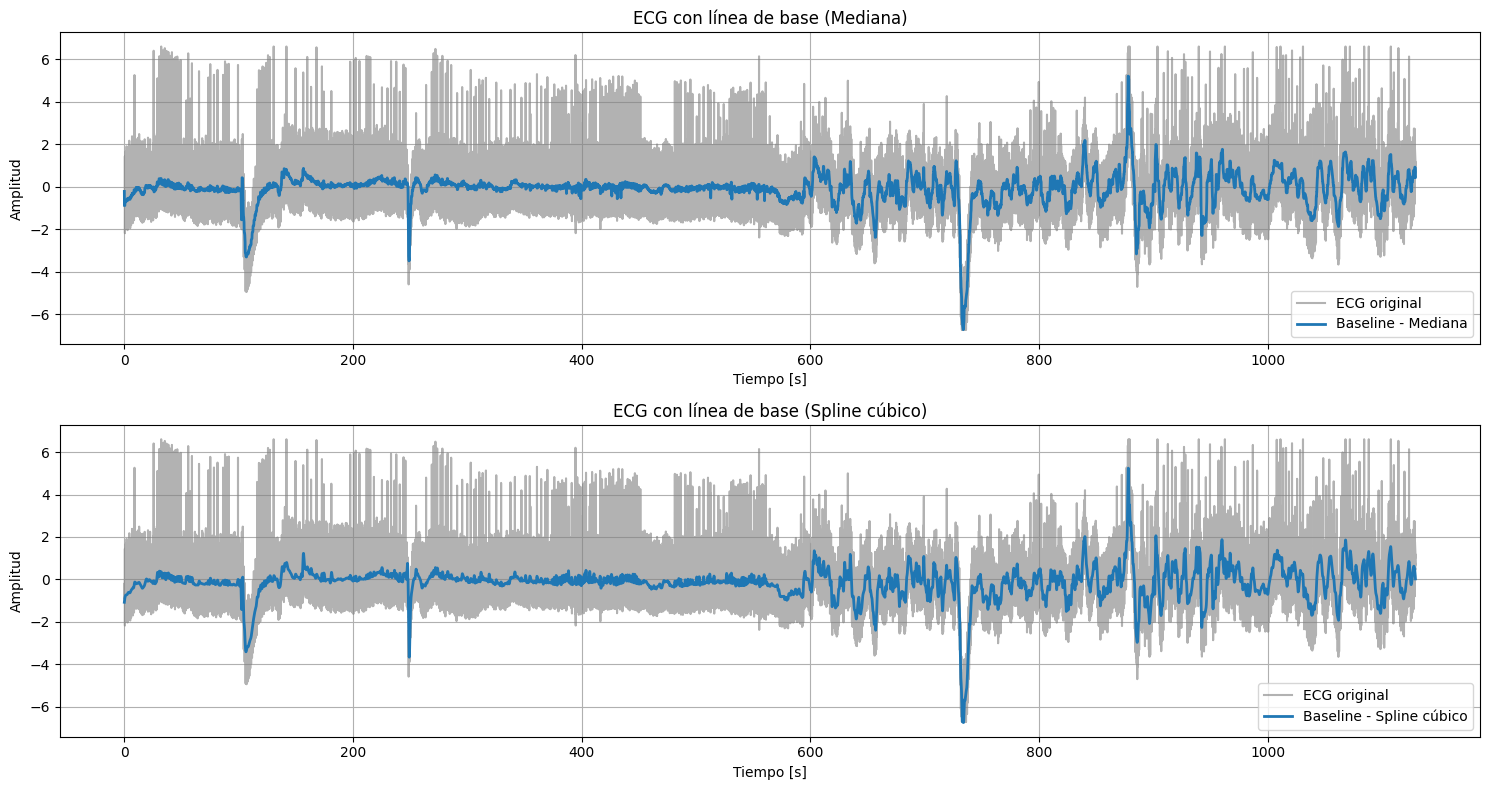

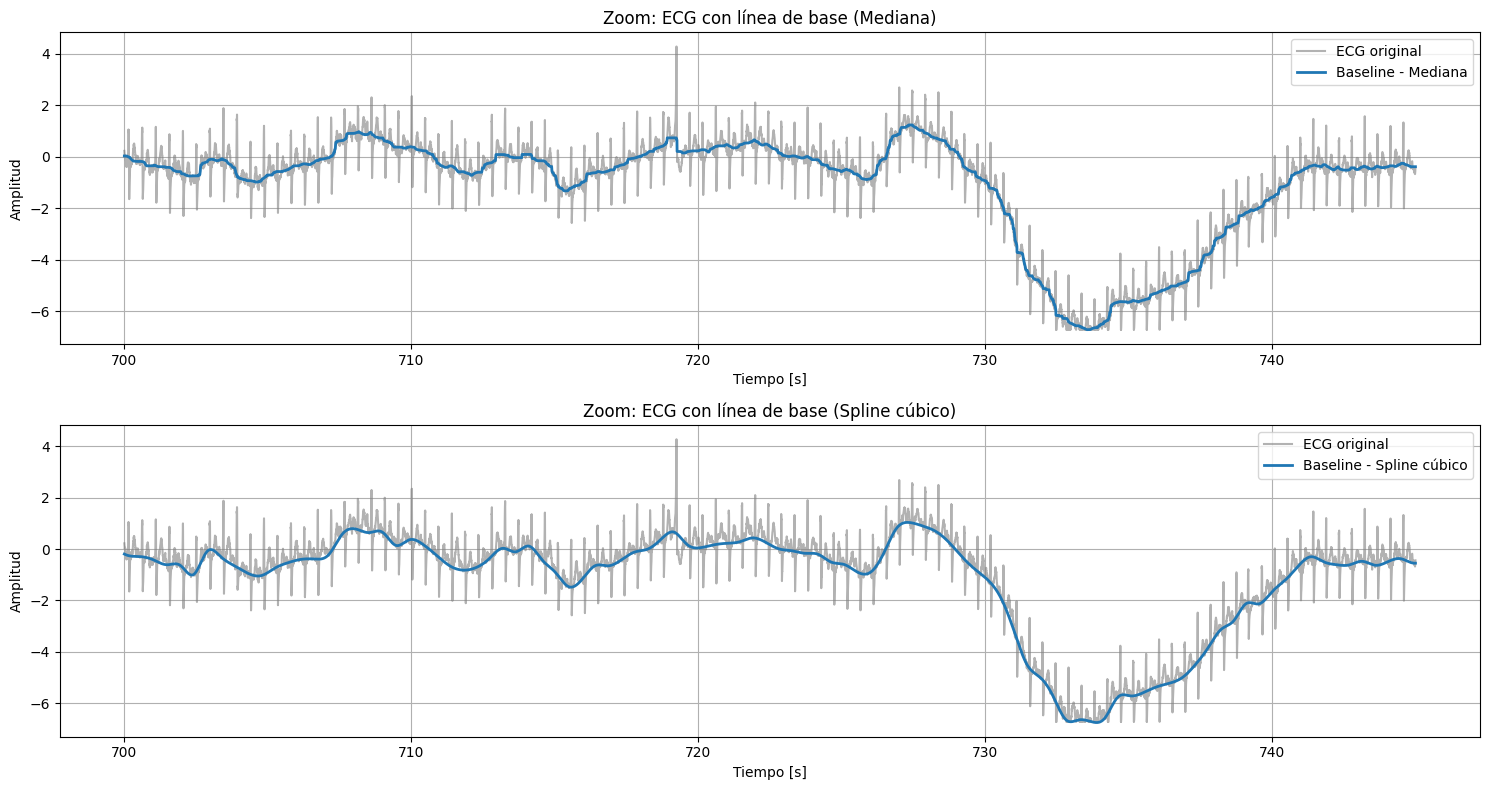

In [2]:
#%% Importado de módulos
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import medfilt
from scipy.interpolate import CubicSpline

#%% Función auxiliar
def vertical_flaten(a):
    return a.reshape(a.shape[0],1)

#%% Carga y preprocesamiento del ECG
fs_ecg = 1000  # Hz

# Carga de la señal ECG
mat_struct = sio.loadmat('./ecg.mat')  # Usamos el mismo archivo para ambos métodos
ecg_one_lead = np.squeeze(mat_struct['ecg_lead']).astype(float)

# Normalización
ecg_one_lead = (ecg_one_lead - np.mean(ecg_one_lead)) / np.std(ecg_one_lead)

# Tiempo total
t_ecg = np.arange(len(ecg_one_lead)) / fs_ecg

#%% --- Filtro de mediana (Baseline por mediana) ---
win1_samples = 200
win2_samples = 600

# Asegurar que sean impares
if win1_samples % 2 == 0:
    win1_samples += 1
if win2_samples % 2 == 0:
    win2_samples += 1

# Aplicación de los filtros
ecg_med1 = medfilt(ecg_one_lead, kernel_size=win1_samples)
baseline_median = medfilt(ecg_med1, kernel_size=win2_samples)

#%% --- Filtro por splines cúbicos (Baseline por spline) ---
qrs_detections = np.squeeze(mat_struct['qrs_detections']).astype(int)

# Punto de interés: 90 muestras antes del QRS
Point_of_Interest = qrs_detections - 90
Point_of_Interest = Point_of_Interest[(Point_of_Interest >= 0) & (Point_of_Interest + 20 < len(ecg_one_lead))]

# Cálculo del promedio en una ventana de 20 muestras
t_prom = []
val_prom = []

for idx in Point_of_Interest:
    window = ecg_one_lead[idx : idx + 20]
    prom = np.mean(window)
    t_prom.append(idx / fs_ecg)
    val_prom.append(prom)

t_prom = np.array(t_prom)
val_prom = np.array(val_prom)

# Spline cúbico
cs = CubicSpline(t_prom, val_prom)
baseline_spline = cs(t_ecg)


#%% --- Gráfico 1: Señal completa con sus dos baselines ---
plt.figure(figsize=(15, 8))

# Subplot 1: Baseline por mediana
plt.subplot(2, 1, 1)
plt.plot(t_ecg, ecg_one_lead, label='ECG original', color='gray', alpha=0.6)
plt.plot(t_ecg, baseline_median, label='Baseline - Mediana', linewidth=2)
plt.title('ECG con línea de base (Mediana)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Baseline por spline cúbico
plt.subplot(2, 1, 2)
plt.plot(t_ecg, ecg_one_lead, label='ECG original', color='gray', alpha=0.6)
plt.plot(t_ecg, baseline_spline, label='Baseline - Spline cúbico', linewidth=2)
plt.title('ECG con línea de base (Spline cúbico)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#%% --- Gráfico 2: Zoom en muestras 700.000 a 745.000 ---
start = 700000
end = 745000
t_zoom = t_ecg[start:end]
ecg_zoom = ecg_one_lead[start:end]
baseline_median_zoom = baseline_median[start:end]
baseline_spline_zoom = baseline_spline[start:end]

plt.figure(figsize=(15, 8))

# Subplot 1: Baseline por mediana (zoom)
plt.subplot(2, 1, 1)
plt.plot(t_zoom, ecg_zoom, label='ECG original', color='gray', alpha=0.6)
plt.plot(t_zoom, baseline_median_zoom, label='Baseline - Mediana', linewidth=2)
plt.title('Zoom: ECG con línea de base (Mediana)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Baseline por spline cúbico (zoom)
plt.subplot(2, 1, 2)
plt.plot(t_zoom, ecg_zoom, label='ECG original', color='gray', alpha=0.6)
plt.plot(t_zoom, baseline_spline_zoom, label='Baseline - Spline cúbico', linewidth=2)
plt.title('Zoom: ECG con línea de base (Spline cúbico)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Análisis de los Resultados

En este análisis utilizamos los métodos de **mediana** y de **splines cúbicos** para estimar la línea de base (baseline) de la señal ECG.  
Como se observa, ambos métodos proporcionan una estimación adecuada de dicha línea de base.  
Al restarla de la señal original, logramos **filtrar** el ECG eliminando esa componente lenta que enmascara el contenido útil de la señal (ruido de baja frecuencia).

Al hacer un **zoom** en una región con alto contenido de ruido, se aprecia que incluso ante grandes oscilaciones, ambos métodos estiman correctamente la línea de base.  
Particularmente, en la zona cercana a los **719 segundos**, donde se presenta un **latido ectópico** (que puede parecerse a una delta), se puede ver una mejora notable:  
en métodos clásicos de filtrado lineal, este tipo de evento genera una **respuesta al impulso** que deforma la morfología de la señal.  
Sin embargo, con estos **métodos no lineales**, ese fenómeno no ocurre, preservando la forma del ECG tras eventos abruptos.

Finalmente, en cuanto a la implementación:

- El método con **filtro de mediana** resulta mucho más **directo y sencillo** de aplicar.
- Por el contrario, el uso de **splines cúbicos** requiere una identificación previa de una zona estable de la señal (cercana al segmento PQ), donde se pueda asumir que la línea de base predomina, y así obtener puntos válidos para la interpolación.

En resumen, ambos métodos son eficaces, pero el filtro de mediana ofrece ventajas prácticas en términos de simplicidad de implementación.

---

Vamos con el Match Filter:


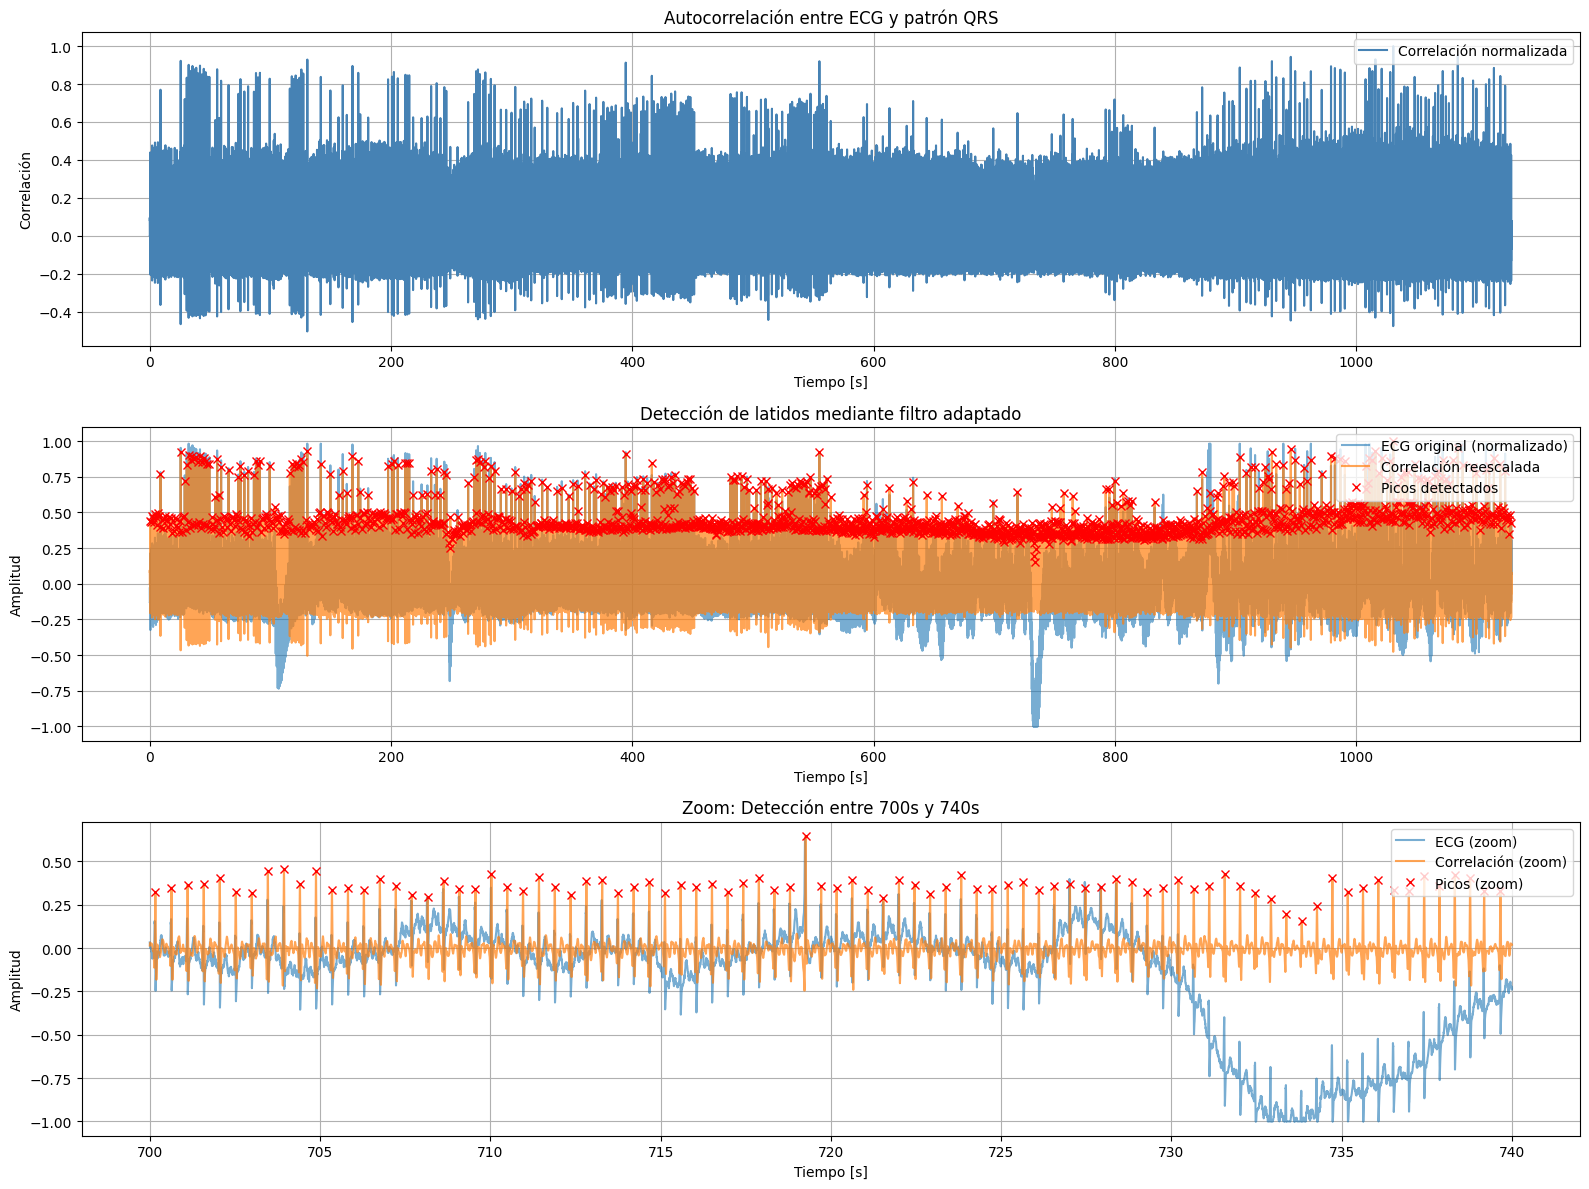

In [6]:
#%% Importación de módulos
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import find_peaks

#%% Lectura de datos
fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ecg.mat')

# Señal original y patrón
ecg_one_lead = np.squeeze(mat_struct['ecg_lead']).astype(float)
qrs_pattern = np.squeeze(mat_struct['qrs_pattern1']).astype(float)

# Tiempo
t_ecg = np.arange(len(ecg_one_lead)) / fs_ecg

#%% Normalización
ecg_norm = (ecg_one_lead - np.mean(ecg_one_lead)) / np.std(ecg_one_lead)
qrs_pattern_norm = (qrs_pattern - np.mean(qrs_pattern)) / np.std(qrs_pattern)

#%% Correlación cruzada normalizada
corr_norm = sig.correlate(ecg_norm, qrs_pattern_norm, mode='same')

# Reescalado para comparación
ecg_rescaled = ecg_norm / np.max(np.abs(ecg_norm))
corr_rescaled = corr_norm / np.max(np.abs(corr_norm))

#%% Detección de picos
threshold = 0.15  # Ajustado tras inspección visual
peaks, _ = find_peaks(corr_rescaled, height=threshold, distance=200)

#%% Gráficos - Subplot 3x1
plt.figure(figsize=(16, 12))

# Subplot 1: Autocorrelación completa
plt.subplot(3, 1, 1)
plt.plot(t_ecg, corr_rescaled, color='steelblue', label='Correlación normalizada')
plt.title('Autocorrelación entre ECG y patrón QRS')
plt.xlabel('Tiempo [s]')
plt.ylabel('Correlación')
plt.grid(True)
plt.legend(loc='upper right')

# Subplot 2: Señal + correlación + picos
plt.subplot(3, 1, 2)
plt.plot(t_ecg, ecg_rescaled, label='ECG original (normalizado)', alpha=0.6)
plt.plot(t_ecg, corr_rescaled, label='Correlación reescalada', alpha=0.7)
plt.plot(t_ecg[peaks], corr_rescaled[peaks], 'rx', label='Picos detectados')
plt.title('Detección de latidos mediante filtro adaptado')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend(loc='upper right')

# Subplot 3: Zoom en la zona de 700s a 740s
plt.subplot(3, 1, 3)
start = 700_000
end = 740_000
plt.plot(t_ecg[start:end], ecg_rescaled[start:end], label='ECG (zoom)', alpha=0.6)
plt.plot(t_ecg[start:end], corr_rescaled[start:end], label='Correlación (zoom)', alpha=0.7)
zoom_peaks = peaks[(peaks >= start) & (peaks < end)]
plt.plot(t_ecg[zoom_peaks], corr_rescaled[zoom_peaks], 'rx', label='Picos (zoom)')
plt.title('Zoom: Detección entre 700s y 740s')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Analisis de lo obtenido

a) Explique conceptualmente cómo podría realizar un detector de latidos con la señal resultante del filtro adaptado. Discuta la utilidad y limitaciones de este método.

El detector de latidos basado en un **filtro adaptado** (*matched filter*) se fundamenta en una idea simple: si conocemos la forma típica de un latido, podemos buscar esa forma dentro de la señal completa mediante correlación.

#### ¿Cómo funciona?

1. **Selección de un patrón QRS**  
   Se toma un latido representativo de la señal —por ejemplo, un complejo QRS típico— para usarlo como *patrón de referencia*.

2. **Correlación cruzada**  
   Se calcula la correlación entre el patrón y la señal completa. Este proceso compara la forma del patrón con todas las partes de la señal.  
   - Si una porción de la señal se parece al patrón, el valor de la correlación será alto.
   - Si no se parece (por ejemplo, en presencia de ruido o segmentos planos), el valor será bajo.

3. **Detección de picos**  
   Los máximos locales de la señal de correlación indican posibles posiciones de latidos. Esto se debe a que la correlación fue máxima en esos puntos, es decir, donde la señal "se parece" más al patrón.

---

#### ¿Por qué este método también actúa como filtro?

El ruido es típicamente **no correlacionado** con el patrón, por lo que la salida del filtro en regiones de ruido tiende a ser baja. Por eso, además de detectar latidos, el método actúa como una forma de **filtrado no lineal**, atenuando ruido irrelevante.

---

#### Ventajas del método:

- **Robustez frente al ruido:** filtra automáticamente componentes que no coinciden con el patrón.
- **Reglas de decisión simples:** basta con detectar picos por encima de un umbral.
- **Implementación directa:** sólo se requiere una operación de correlación.

---

#### Limitaciones:

- **Dependencia del patrón:** si el patrón de QRS no es representativo (por ejemplo, por ruido, morfología atípica, o latidos ectópicos), la correlación puede fallar.
- **Sensibilidad a la variabilidad:** los latidos pueden variar con el tiempo, y el patrón fijo puede no adaptarse bien a todos ellos.
- **Falsos positivos:** estructuras parecidas al patrón, como artefactos o latidos ectópicos, también generan una alta correlación, aunque no sean latidos normales.

---

**En resumen**, este método es muy útil cuando se cuenta con un patrón de latido limpio y representativo. Sin embargo, su desempeño se degrada si hay mucha variabilidad en los latidos o si el patrón no está bien elegido. Por eso, suele combinarse con otros criterios o métodos para mejorar su robustez.

---
---

Veamos algunas metricas para evaluar la potencia de esta detección

In [7]:
#%% Evaluación: matriz de confusión con Pandas
import pandas as pd

# Supuesto: anotaciones reales están en 'qrs_detections' (ajusta si es necesario)
print(mat_struct.keys())  # Verifica el nombre real si es necesario
qrs_true = np.squeeze(mat_struct['qrs_detections']).astype(int)  # Ajusta aquí si cambia el nombre

# Tolerancia de coincidencia: ±100 ms en muestras
tolerance_samples = int(0.1 * fs_ecg)

# Inicializar contadores
TP = 0  # Verdaderos positivos
FP = 0  # Falsos positivos
FN = 0  # Falsos negativos

detected_true = np.zeros(len(qrs_true), dtype=bool)

# Comparar cada pico detectado con los QRS reales
for detected_peak in peaks:
    match_found = False
    for i, true_peak in enumerate(qrs_true):
        if not detected_true[i] and abs(detected_peak - true_peak) <= tolerance_samples:
            TP += 1
            detected_true[i] = True
            match_found = True
            break
    if not match_found:
        FP += 1

# Falsos negativos: QRS reales no detectados
FN = np.sum(~detected_true)

# Métricas
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Crear tabla de confusión con pandas
confusion_data = {
    'Detección': ['Positiva', 'Negativa'],
    'QRS Real Positivo': [TP, FN],
    'QRS Real Negativo': [FP, 'N/A'],  # N/A para claridad
}
confusion_df = pd.DataFrame(confusion_data)
confusion_df.set_index('Detección', inplace=True)

# Mostrar resultados
print("\n=== Tabla de Confusión ===")
display(confusion_df)

# Métricas adicionales
metrics_df = pd.DataFrame({
    'Precisión': [precision],
    'Recall (Sensibilidad)': [recall],
    'F1 Score': [f1_score]
})

print("=== Métricas de Evaluación ===")
display(metrics_df.style.format("{:.2f}"))


dict_keys(['__header__', '__version__', '__globals__', 'ecg_lead', 'qrs_pattern1', 'heartbeat_pattern1', 'heartbeat_pattern2', 'qrs_detections'])

=== Tabla de Confusión ===


,QRS Real Positivo,QRS Real Negativo
Detección,,
Positiva,1902,3
Negativa,1,N/A


=== Métricas de Evaluación ===


,Precisión,Recall (Sensibilidad),F1 Score
0,1.00,1.00,1.00


### Evaluación de la detección de QRS con tabla de confusión

Una vez detectados los latidos (QRS) con correlación cruzada, evaluamos qué tan bien funciona el algoritmo usando una **tabla de confusión**.

---

#### ¿Qué es una tabla de confusión?

Es una herramienta que compara lo que detecta el algoritmo con la realidad (QRS reales anotados):

|                        | QRS Real (Presente) | QRS No Real (Ausente) |
|------------------------|---------------------|------------------------|
| **Detección Positiva** | TP (Correcto)       | FP (Error)            |
| **Detección Negativa** | FN (Omisión)        | N/A                   |

- **TP (Verdaderos Positivos):** Detecciones correctas de latidos reales.
- **FP (Falsos Positivos):** Detecciones donde no hay latido.
- **FN (Falsos Negativos):** Latidos reales que el algoritmo no detectó.

> Como no nos interesa detectar "ausencias de QRS", la celda TN (Verdadero Negativo) no aplica y se marca como N/A.

---

#### Métricas evaluadas

- **Precisión:** Proporción de detecciones que fueron correctas.  
  $$
  \text{Precisión} = \frac{TP}{TP + FP}
  $$

- **Sensibilidad (Recall):** Proporción de latidos reales detectados.  
  $$
  \text{Sensibilidad} = \frac{TP}{TP + FN}
  $$

- **F1 Score:** Promedio balanceado entre precisión y sensibilidad.  
  $$
  F1 = 2 \cdot \frac{\text{Precisión} \cdot \text{Sensibilidad}}{\text{Precisión} + \text{Sensibilidad}}
  $$

---

#### ¿Para qué sirve?

Estas métricas permiten saber si:

- El algoritmo **detecta la mayoría de los QRS reales** (alta sensibilidad).
- **No detecta latidos falsos** (alta precisión).
- Tiene un **buen equilibrio** entre ambos (alto F1 Score).

Esto es fundamental antes de aplicar el detector en contextos reales o clínicos.

---

#### ¿Como nos dio el detector?

Habiendo introducido esto, vemos que la performance de nuestras detecciones es practicamente la misma que lo que teniamos en el archivo de referencia. De esta manera podemos asegurar que lo obtenido en el detector de latidos que realizamos está funcionando correctamente. 

## Bonus

💎 **¿Podría funcionar el detector basado en un filtro adaptado utilizando un latido proveniente de otro registro o paciente?**

No necesariamente. Si bien es posible que el detector funcione, su efectividad dependerá en gran medida de **qué tan representativo sea el latido utilizado como plantilla** en relación con los latidos reales del paciente que se desea analizar.

Si la plantilla proviene de un latido que se asemeja bastante al promedio morfológico del nuevo paciente, el detector podría funcionar con una precisión aceptable. Sin embargo, en la práctica, la **morfología del ECG varía significativamente entre pacientes**, y también puede cambiar dentro de un mismo paciente debido a factores como la postura, el movimiento o condiciones clínicas.

Por lo tanto, si la plantilla utilizada no refleja bien la forma de los latidos del nuevo registro, el filtro adaptado **perderá sensibilidad y especificidad**, generando errores en la detección de los picos (comúnmente los complejos QRS).

En resumen, **la generalización del detector a otros pacientes no está garantizada**, y su desempeño dependerá de la similitud entre la plantilla utilizada y la señal real a analizar.




---
---

# Bonus:

💎 Proponga alguna mejora a los estimadores de la señal  b, como por ejemplo usar las técnicas multirate. 


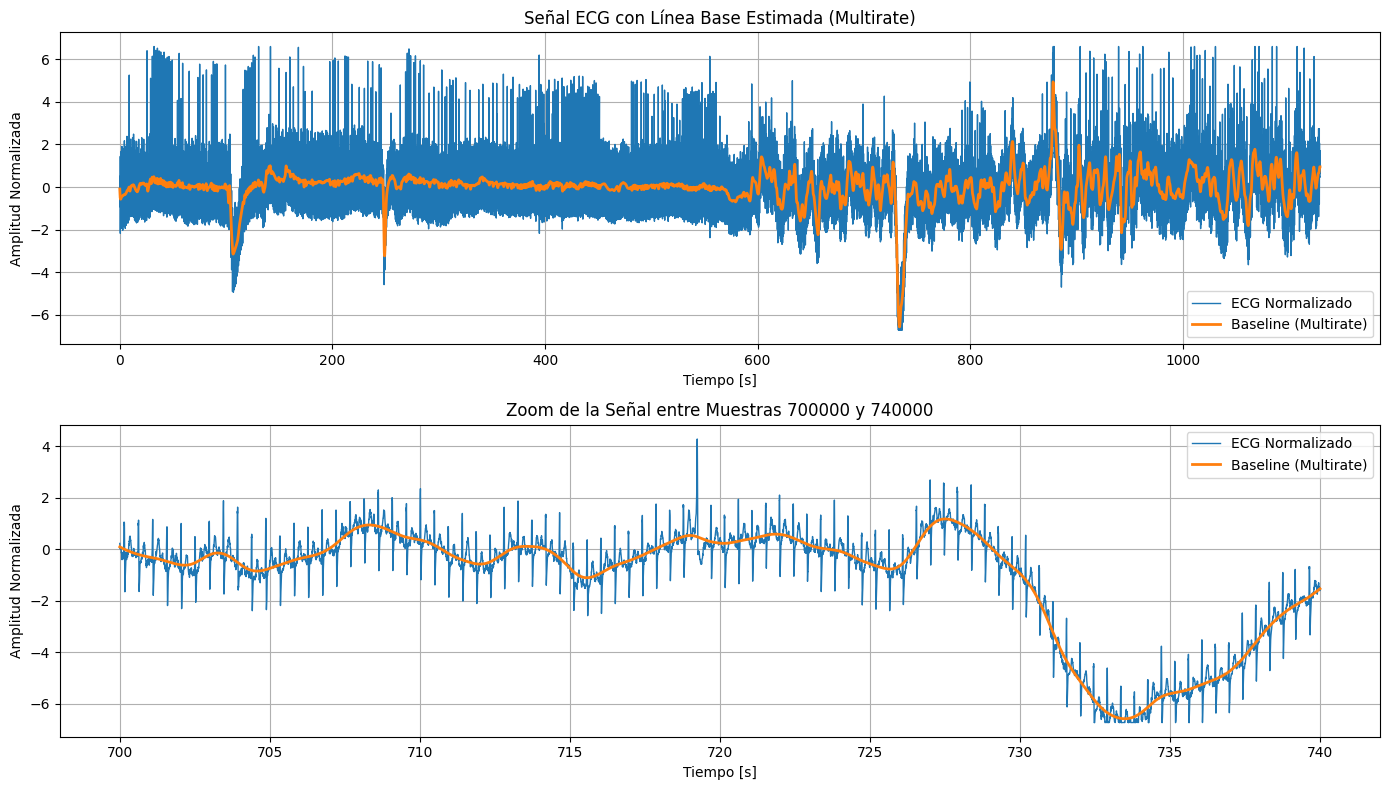

In [13]:
#%% --- Importación de módulos ---
import numpy as np
from scipy import signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import medfilt, decimate
from scipy.interpolate import CubicSpline

#%% --- Carga y preprocesamiento del ECG ---
fs_ecg = 1000  # Hz

# Carga de la señal ECG
mat_struct = sio.loadmat('./ecg.mat')  # Asegúrate de tener ecg.mat en el mismo directorio
ecg_one_lead = np.squeeze(mat_struct['ecg_lead']).astype(float)

# Normalización
ecg_one_lead = (ecg_one_lead - np.mean(ecg_one_lead)) / np.std(ecg_one_lead)

# Tiempo total
t_ecg = np.arange(len(ecg_one_lead)) / fs_ecg

#%% --- Estimación de línea base con técnica multirate ---
# Paso 1: Decimación
decimation_factor = 10
ecg_decimated = decimate(ecg_one_lead, decimation_factor, ftype='fir', zero_phase=True)

# Paso 2: Filtrado pasa-bajo
cutoff_freq = 0.5  # Hz
fs_decimated = fs_ecg / decimation_factor
nyq = fs_decimated / 2
b, a = sig.butter(2, cutoff_freq / nyq, btype='low')
baseline_low = sig.filtfilt(b, a, ecg_decimated)

# Paso 3: Interpolación cúbica para volver a la frecuencia original
t_decimated = np.arange(len(baseline_low)) * decimation_factor / fs_ecg
cs = CubicSpline(t_decimated, baseline_low)
baseline_multirate = cs(t_ecg)

#%% --- Gráfica con subplot 2x1 ---
plt.figure(figsize=(14, 8))

# Subplot 1: Señal completa con baseline
plt.subplot(2, 1, 1)
plt.plot(t_ecg, ecg_one_lead, label='ECG Normalizado', linewidth=1)
plt.plot(t_ecg, baseline_multirate, label='Baseline (Multirate)', linewidth=2)
plt.title('Señal ECG con Línea Base Estimada (Multirate)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud Normalizada')
plt.legend()
plt.grid(True)

# Subplot 2: Zoom en muestras 700000 a 740000
start_idx = 700_000
end_idx = 740_000
plt.subplot(2, 1, 2)
plt.plot(t_ecg[start_idx:end_idx], ecg_one_lead[start_idx:end_idx], label='ECG Normalizado', linewidth=1)
plt.plot(t_ecg[start_idx:end_idx], baseline_multirate[start_idx:end_idx], label='Baseline (Multirate)', linewidth=2)
plt.title('Zoom de la Señal entre Muestras 700000 y 740000')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud Normalizada')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Comparemos los metodos

### 1. Filtro de Mediana

Utiliza dos filtros de mediana con ventanas de distinto tamaño para suavizar progresivamente la señal y extraer la línea base.

**Ventajas:**
- Robusto frente a artefactos puntuales (como espigas).
- No introduce desfase.
- Fácil de implementar.

**Desventajas:**
- Puede perder oscilaciones fisiológicas lentas.
- La línea base no es suave (puede tener quiebres).

---

### 2. Técnica Multirate (Decimación + Filtro + Interpolación)

Basada en el hecho de que la línea base es una componente de **muy baja frecuencia**. El proceso consiste en:

1. **Decimación**: se reduce la tasa de muestreo, eliminando contenido de alta frecuencia.
2. **Filtrado pasa-bajo**: se retienen sólo las variaciones lentas.
3. **Interpolación (por splines)**: se recupera la línea base en la tasa de muestreo original de forma suave.

**Ventajas:**
- Excelente seguimiento de variaciones lentas (como la respiración).
- La línea base resultante es suave y continua.
- Buena separación espectral entre señal útil y línea base.

**Desventajas:**
- Requiere más procesamiento.
- Puede suavizar en exceso si no se eligen bien los parámetros.

---

Cada técnica tiene ventajas según el tipo de señal y el objetivo clínico. El filtro de mediana es ideal para eliminar artefactos, mientras que la técnica multirate es superior cuando se desea conservar las variaciones fisiológicas lentas.

